# -------------------HEALTH PREDICTIVE ANALYSIS------------------------

In [76]:
import pandas as pd
import numpy as np
import math
import datetime
from pandas.api.types import is_datetime64_any_dtype as is_datetime

from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix,classification_report

from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from xgboost import plot_tree
import graphviz


import warnings
warnings.filterwarnings('ignore')

In [77]:
#-------import  and display dataset----------
data = pd.read_csv("C:\\Users\\Kasutaja\\Downloads\\RawInternshipFiles\\cardio_health.csv")
data.head(5)

,date,country,id,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
0,03/05/2021,Indonesia,0,1,18393,0,110,80,1,2,1,168,Architect,0,62.0,0
1,05/08/2021,Malaysia,1,1,20228,0,140,90,3,1,1,156,Accountant,0,85.0,1
2,13/11/2022,Indonesia,2,0,18857,0,130,70,3,1,1,165,Chef,0,64.0,1
3,31/10/2018,Singapore,3,1,17623,0,150,100,1,2,1,169,Lawyer,0,82.0,1
4,25/09/2020,Singapore,4,0,17474,0,100,60,1,1,1,156,Architect,0,56.0,0


# --------------------------DATA WRANGLING---------------------------------

In [78]:
#----------count number of unique values in each columns---------
data.nunique()

date            1827
country            4
id             70000
active             2
age             8076
alco               2
ap_hi            153
ap_lo            157
cholesterol        3
gender             2
gluc               3
height           109
occupation         9
smoke              2
weight           287
disease            2
dtype: int64

In [79]:
#-------dataset information---------
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         70000 non-null  object 
 1   country      70000 non-null  object 
 2   id           70000 non-null  int64  
 3   active       70000 non-null  int64  
 4   age          70000 non-null  int64  
 5   alco         70000 non-null  int64  
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gender       70000 non-null  int64  
 10  gluc         70000 non-null  int64  
 11  height       70000 non-null  int64  
 12  occupation   70000 non-null  object 
 13  smoke        70000 non-null  int64  
 14  weight       70000 non-null  float64
 15  disease      70000 non-null  int64  
dtypes: float64(1), int64(12), object(3)
memory usage: 8.5+ MB


In [80]:
#------------check blank rows------------ 
data.isnull().all().sum()

0

In [81]:
#------check duplicate ----------
data.duplicated().sum()* 100/len(data)

0.0

In [82]:
#----Changing datatype---------
data['date'] = pd.to_datetime(data['date'], dayfirst = True)

In [83]:
#---------Age is in days instead of years-------------
data['age'].iloc[:2]

0    18393
1    20228
Name: age, dtype: int64

In [84]:
#----------change wrong format(Age needs to be converted to years)----------------
days = 365
data['age']  = data['age'].apply(lambda x:  math.trunc(x/days))


In [85]:
#----------print all date columns------------------
dat_features = [dat for dat in data if is_datetime(data[dat])]

print(f' Date columns -',[len(dat_features)])
print({*dat_features}, sep = ",")

 Date columns - [1]
{'date'}


In [86]:
#-----------drop some columns for futher anaysis----------------
data = data.drop(columns = [ 'id','date'], axis = 1)

In [87]:
#-----print all numerical and categorical columns-------------

num_features = [num for num in data if data[num].dtype!= object]
cat_features = [cat for cat in data if data[cat].dtype == object]


print(f' Numerical columns-', [len(num_features)])
print({*num_features}, sep=",")
print(f' Categorical columns -',[len(cat_features)])
print({*cat_features}, sep = ",")



 Numerical columns- [12]
{'smoke', 'disease', 'ap_lo', 'age', 'ap_hi', 'gender', 'height', 'cholesterol', 'weight', 'gluc', 'active', 'alco'}
 Categorical columns - [2]
{'occupation', 'country'}


In [88]:
#-----display dataset-----------
data.iloc[0:6]

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
0,Indonesia,1,50,0,110,80,1,2,1,168,Architect,0,62.0,0
1,Malaysia,1,55,0,140,90,3,1,1,156,Accountant,0,85.0,1
2,Indonesia,0,51,0,130,70,3,1,1,165,Chef,0,64.0,1
3,Singapore,1,48,0,150,100,1,2,1,169,Lawyer,0,82.0,1
4,Singapore,0,47,0,100,60,1,1,1,156,Architect,0,56.0,0
5,Indonesia,0,60,0,120,80,2,1,2,151,Teacher,0,67.0,0


# -------------------------- Statististcal Analysis (Summarization)-----------------------------


In [89]:
#---------statistic summary----------------------
data.describe(include=[np.number]).round()

,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,smoke,weight,disease
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0
mean,1.0,53.0,0.0,129.0,97.0,1.0,1.0,1.0,164.0,0.0,74.0,0.0
std,0.0,7.0,0.0,154.0,188.0,1.0,0.0,1.0,8.0,0.0,14.0,1.0
min,0.0,29.0,0.0,-150.0,-70.0,1.0,1.0,1.0,55.0,0.0,10.0,0.0
25%,1.0,48.0,0.0,120.0,80.0,1.0,1.0,1.0,159.0,0.0,65.0,0.0
50%,1.0,53.0,0.0,120.0,80.0,1.0,1.0,1.0,165.0,0.0,72.0,0.0
75%,1.0,58.0,0.0,140.0,90.0,2.0,2.0,1.0,170.0,0.0,82.0,1.0
max,1.0,64.0,1.0,16020.0,11000.0,3.0,2.0,3.0,250.0,1.0,200.0,1.0


In [90]:
#---------count disease by country--------------
print("disease: ", data[data["disease"] == 1].count()["country"])

print("Non_disease:", data[data["disease"]== 0].count()["country"])

disease:  34979
Non_disease: 35021


In [91]:
#---------grouped age and count----------
cats = pd.cut(data.age, 5, precision=0)
pd.value_counts(cats)

age
(50.0, 57.0]    25340
(57.0, 64.0]    20035
(43.0, 50.0]    15867
(36.0, 43.0]     8754
(29.0, 36.0]        4
Name: count, dtype: int64

In [92]:
#----summary of speacific columns---------------
pd.crosstab(data['disease'],data['smoke'],margins = True)

smoke,0,1,All
disease,,,
0,31781,3240,35021
1,32050,2929,34979
All,63831,6169,70000


# ----------------------Data Exploratory (Graphical Analysis)---------------------------------

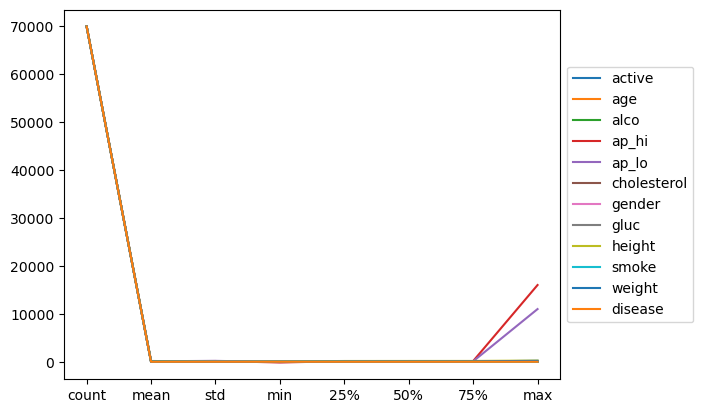

In [93]:
#-------------visualize statistical result------------------
data.describe().plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))

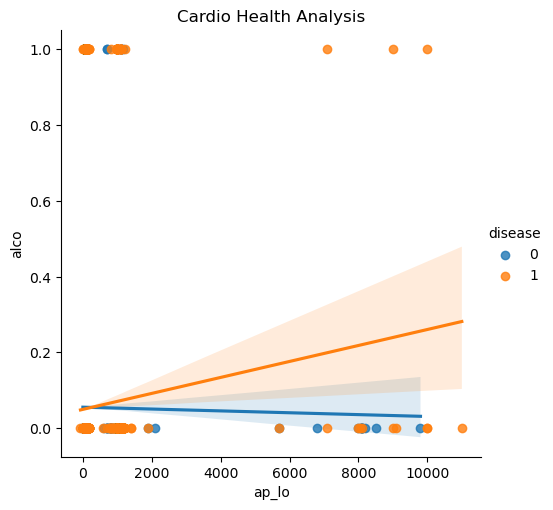

In [94]:
#---------linear model Plot presentation of the correlation of specific columns-----------
sns.lmplot(x="ap_lo", y="alco", hue="disease", data=data)
plt.title('Cardio Health Analysis')
plt.show()

<Axes: >

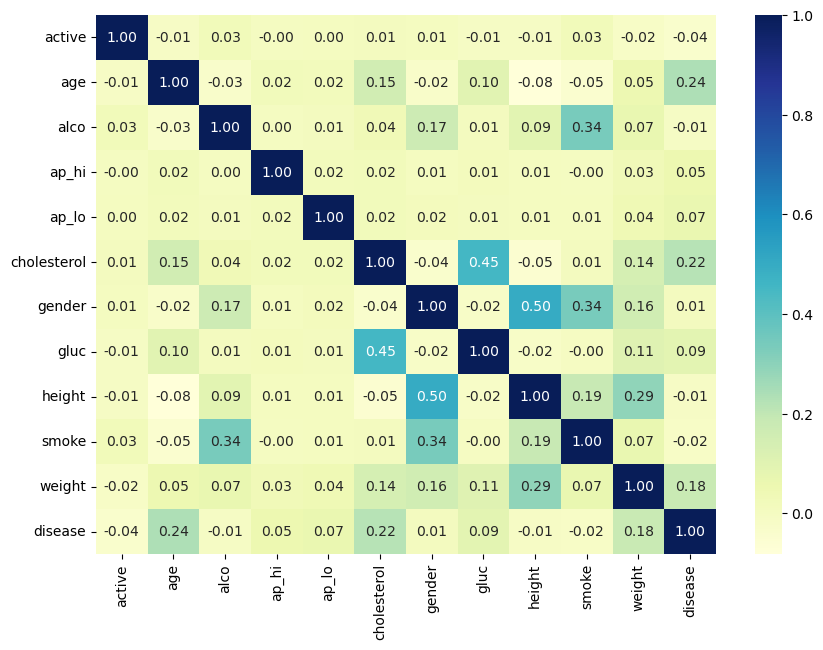

In [95]:
#---------Heatmap presentation of data correlation-------------------------
#remove non numeric 
data_numeric = data.select_dtypes(include = ['float','int']) 
#defining the correlation function
corr = data_numeric.corr()
plt.figure(figsize =(10,7))
sns.heatmap(corr,annot = True, fmt= ".2f", cmap = "YlGnBu")


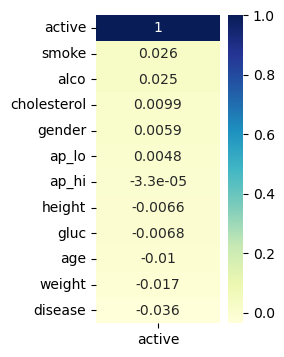

In [96]:
#---------Data correlation sorted by Active columns using heatmap plot-----------------------
sort_corr = data_numeric.corr()[['active']].sort_values(by='active',ascending=False)
plt.figure(figsize=(2,4))
corr = sns.heatmap(sort_corr, annot=True, cmap='YlGnBu', cbar=True)

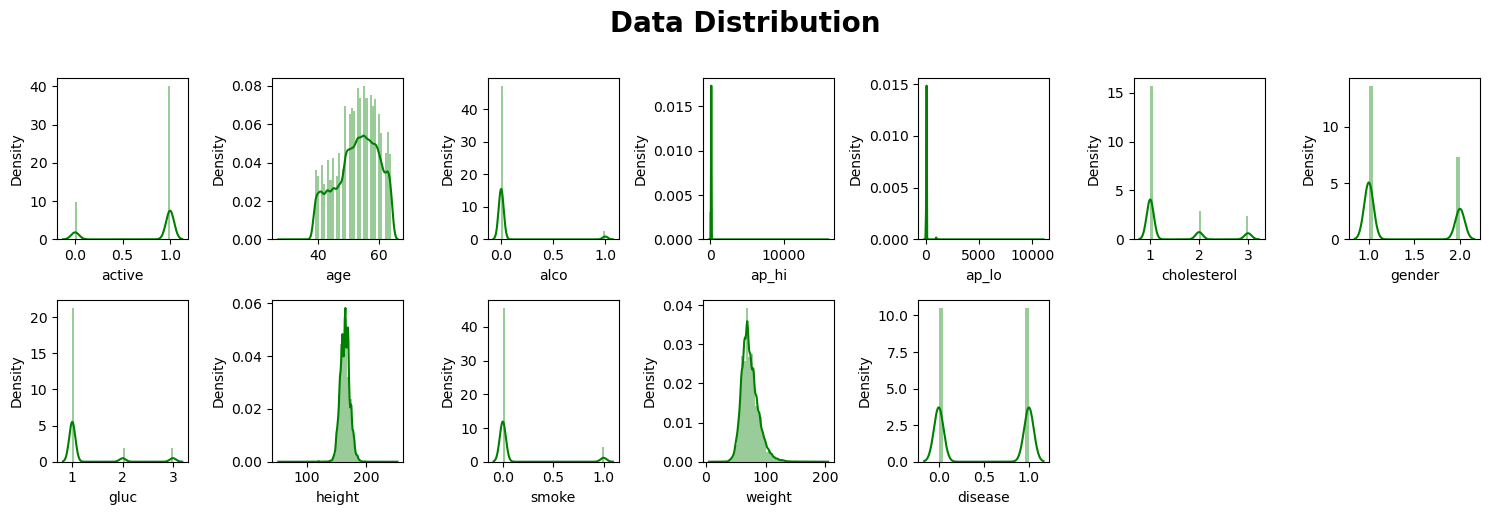

In [97]:
#---------- Plot the Data Distribution------------
plt.figure(figsize=(15,5))
# title
plt.suptitle('Data Distribution', fontsize=20, fontweight='bold', y=1.02)

for i,colns in enumerate(num_features):
  plt.subplot(2, 7, i+1)                      
  # dist plot
  sns.distplot(data[colns], color = 'green')  
  # x-axis label
  plt.xlabel(colns)
  plt.tight_layout()    
     

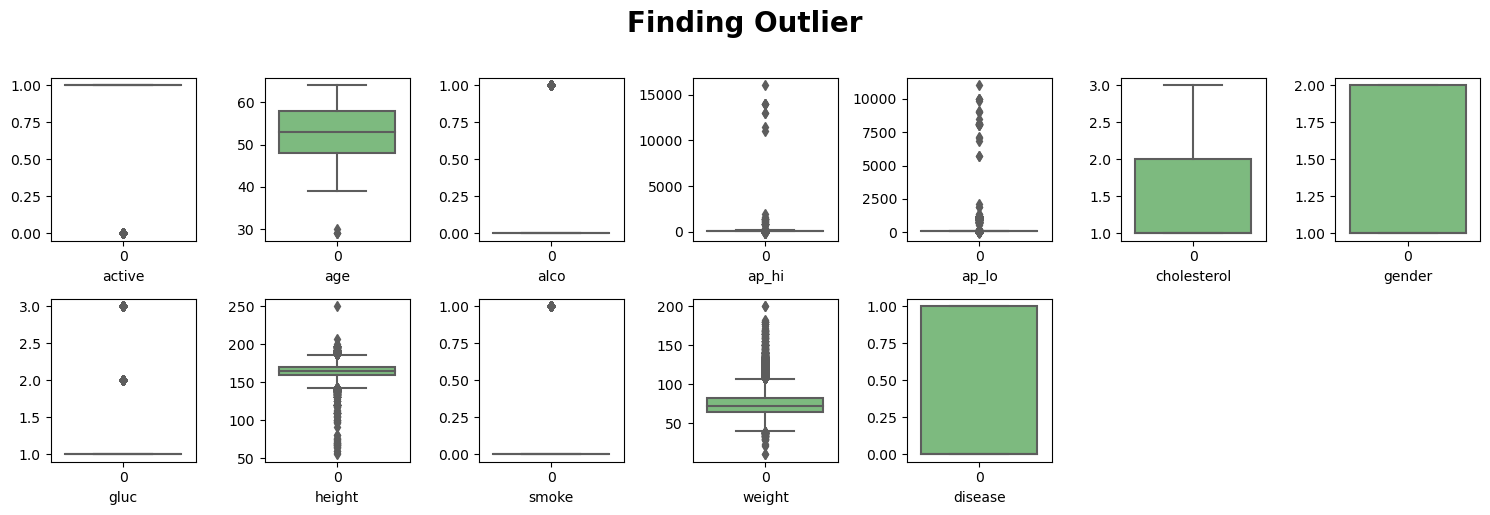

In [98]:
#-------------Find and Plot Outliers--------------
plt.figure(figsize=(15,5))
# title
plt.suptitle('Finding Outlier', fontsize=20, fontweight='bold', y = 1.02)

for i,colns in enumerate(num_features):
  plt.subplot(2, 7, i+1)                    
     # subplots 2 rows, 7 columns
  # plot boxplots
  sns.boxplot(data[colns], palette="Greens")
  # x-axis label
  plt.xlabel(colns)
  plt.tight_layout()

# -------------------------Machine Learning-------------------------------------------
 

In [99]:
#shortened data for visualization that is at last lines of this page
#data = data.head(200)

In [100]:
#------------------data Preparing  for machine learning----------
x_feat = data.drop(columns = ['gender','occupation','country','disease'], axis = 1)
y_feat = data['disease']

In [101]:
#------display x features------------------
x_feat.head(2)

,active,age,alco,ap_hi,ap_lo,cholesterol,gluc,height,smoke,weight
0,1,50,0,110,80,1,1,168,0,62.0
1,1,55,0,140,90,3,1,156,0,85.0


In [102]:
#------display y features------------------
y_feat.head(2)

0    0
1    1
Name: disease, dtype: int64

In [103]:
 #----------Splitting the dataset into Train and Test dataset----------------
X_train,x_test,y_train,y_test = train_test_split(x_feat,y_feat,train_size = 0.7,
                                                     shuffle = True,random_state = 1)

In [104]:
#----- scaling and standardize datapoints----------
scale= StandardScaler()    
X_train= scale.fit_transform(X_train)    
x_test= scale.transform(x_test) 

In [107]:
X_train

array([[ 0.49783068, -1.30515935, -0.23858509, ...,  0.55926609,
         3.20218977, -0.22543647],
       [ 0.49783068, -1.89594469, -0.23858509, ..., -0.77638496,
        -0.3122863 , -0.36391731],
       [ 0.49783068,  0.46719666, -0.23858509, ..., -0.04784803,
        -0.3122863 , -0.640879  ],
       ...,
       [ 0.49783068, -0.56667768, -0.23858509, ...,  1.65207149,
        -0.3122863 ,  0.53620817],
       [-2.00871508,  1.057982  , -0.23858509, ...,  0.55926609,
        -0.3122863 ,  0.19000606],
       [ 0.49783068,  0.46719666, -0.23858509, ...,  1.1663802 ,
        -0.3122863 , -0.640879  ]])

In [108]:
x_test

array([[ 0.49783068, -1.30515935, -0.23858509, ..., -1.38349908,
        -0.3122863 ,  1.2978528 ],
       [ 0.49783068, -2.04364102, -0.23858509, ..., -0.89780778,
        -0.3122863 ,  1.02089112],
       [ 0.49783068,  0.17180399, -0.23858509, ...,  0.0735748 ,
        -0.3122863 , -0.57163858],
       ...,
       [ 0.49783068, -1.89594469, -0.23858509, ...,  0.68068891,
        -0.3122863 , -0.43315773],
       [ 0.49783068,  1.057982  , -0.23858509, ...,  0.0735748 ,
        -0.3122863 , -0.57163858],
       [ 0.49783068,  0.614893  , -0.23858509, ..., -0.16927085,
        -0.3122863 , -0.71011942]])

In [109]:
#--------------Create Models------------------

In [110]:
#-----creating dictionary variable that will contain all the models-------
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNeighbor" : KNeighborsClassifier(),
    "XGBClassifier":  XGBClassifier()

}


In [111]:
#----------looping through the variable and diplay the created models---------------
for i,x in models.items():
    x.fit(X_train,y_train)
    print(i + " model created !")

Logistic Regression model created !
Decision Tree model created !
Random Forest model created !
KNeighbor model created !
XGBClassifier model created !


In [112]:
# ----------Evaluating the all the models--------------------------
accurancy_Container =[]
for names, model in models.items():s
    y_predict = model.predict(x_test)
    score = accuracy_score(y_test, y_predict)
    accurancy_Container.append(score)
    print(names + " Accuracy score: {:.2f}%".format(score * 100))
    print("Precision: {:.2f}%".format(metrics.precision_score(y_test, y_predict) * 100))
    print("Recall: {:.2f}%".format(metrics.recall_score(y_test, y_predict)*100))

Logistic Regression Accuracy score: 71.84%
Precision: 74.89%
Recall: 66.88%
Decision Tree Accuracy score: 63.23%
Precision: 64.32%
Recall: 61.72%
Random Forest Accuracy score: 70.66%
Precision: 71.57%
Recall: 69.91%
KNeighbor Accuracy score: 65.19%
Precision: 66.88%
Recall: 62.11%
XGBClassifier Accuracy score: 73.25%
Precision: 76.12%
Recall: 68.84%


<Axes: >

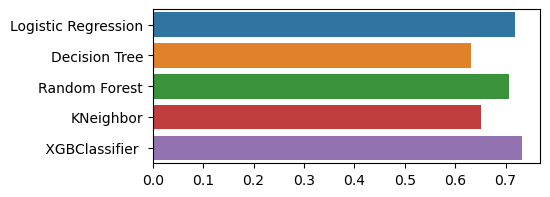

In [113]:
# ------------Graphical presentation of the evaluated models result
model_name=['Logistic Regression','Decision Tree','Random Forest','KNeighbor'," XGBClassifier "]
plt.figure(figsize = (5,2))
sns.barplot(x = accurancy_Container, y = model_name)

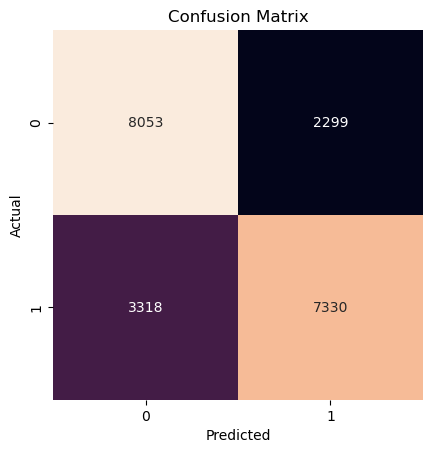

<Figure size 500x200 with 0 Axes>

In [114]:
#-------------- Confusion Matrix Visualization-------------------

sns.heatmap(confusion_matrix(y_test , y_predict), annot=True, fmt='d', square = True , cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.figure(figsize = (5,2))
plt.show()

# ----------------------Visualization of Data--------------------------------------

# Original dataset is very big (70001) rows, therefore the dataset  was reduced to (200) rows for easy visualization purpose. (In line 99: data.head(200)).


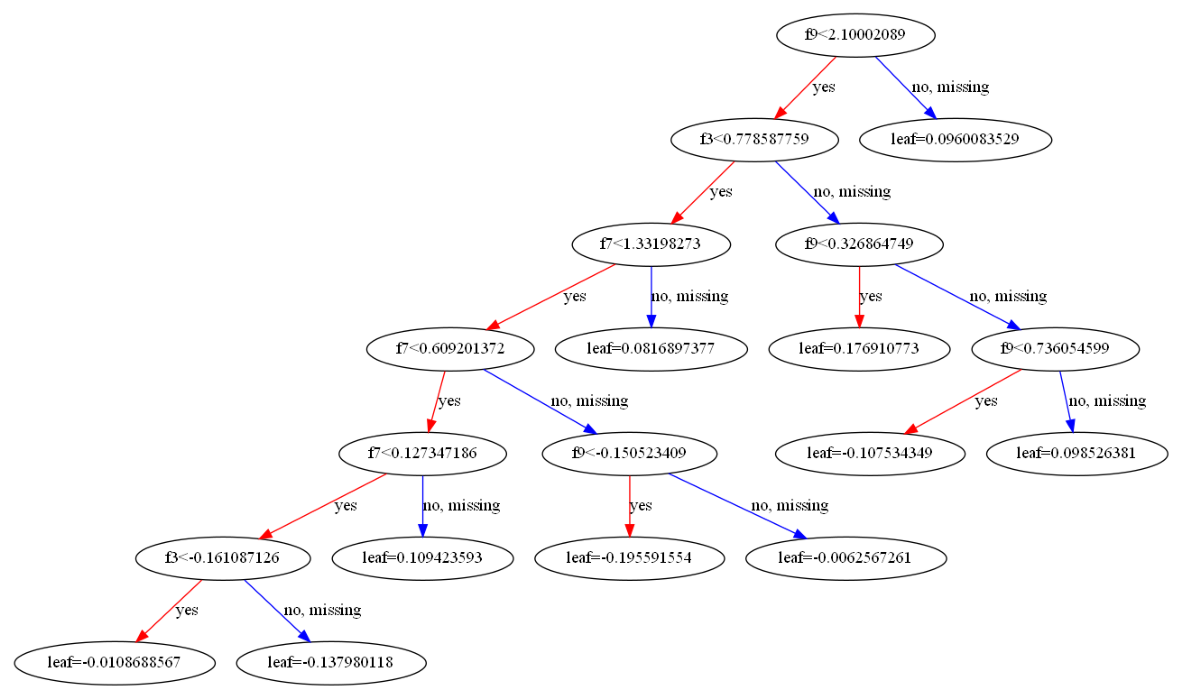

In [39]:
#---------Tree Plotting of XGBClassifier MODEL Outcome----------------------------
plot_tree(models["XGBClassifier"], num_trees= 15, n_first_tree = 2)
plt.gcf().set_size_inches(15, 100)

#plt.savefig("C:\\Users\Kasutaja\\Downloads\\XHealth_picture2.png")
plt.show()

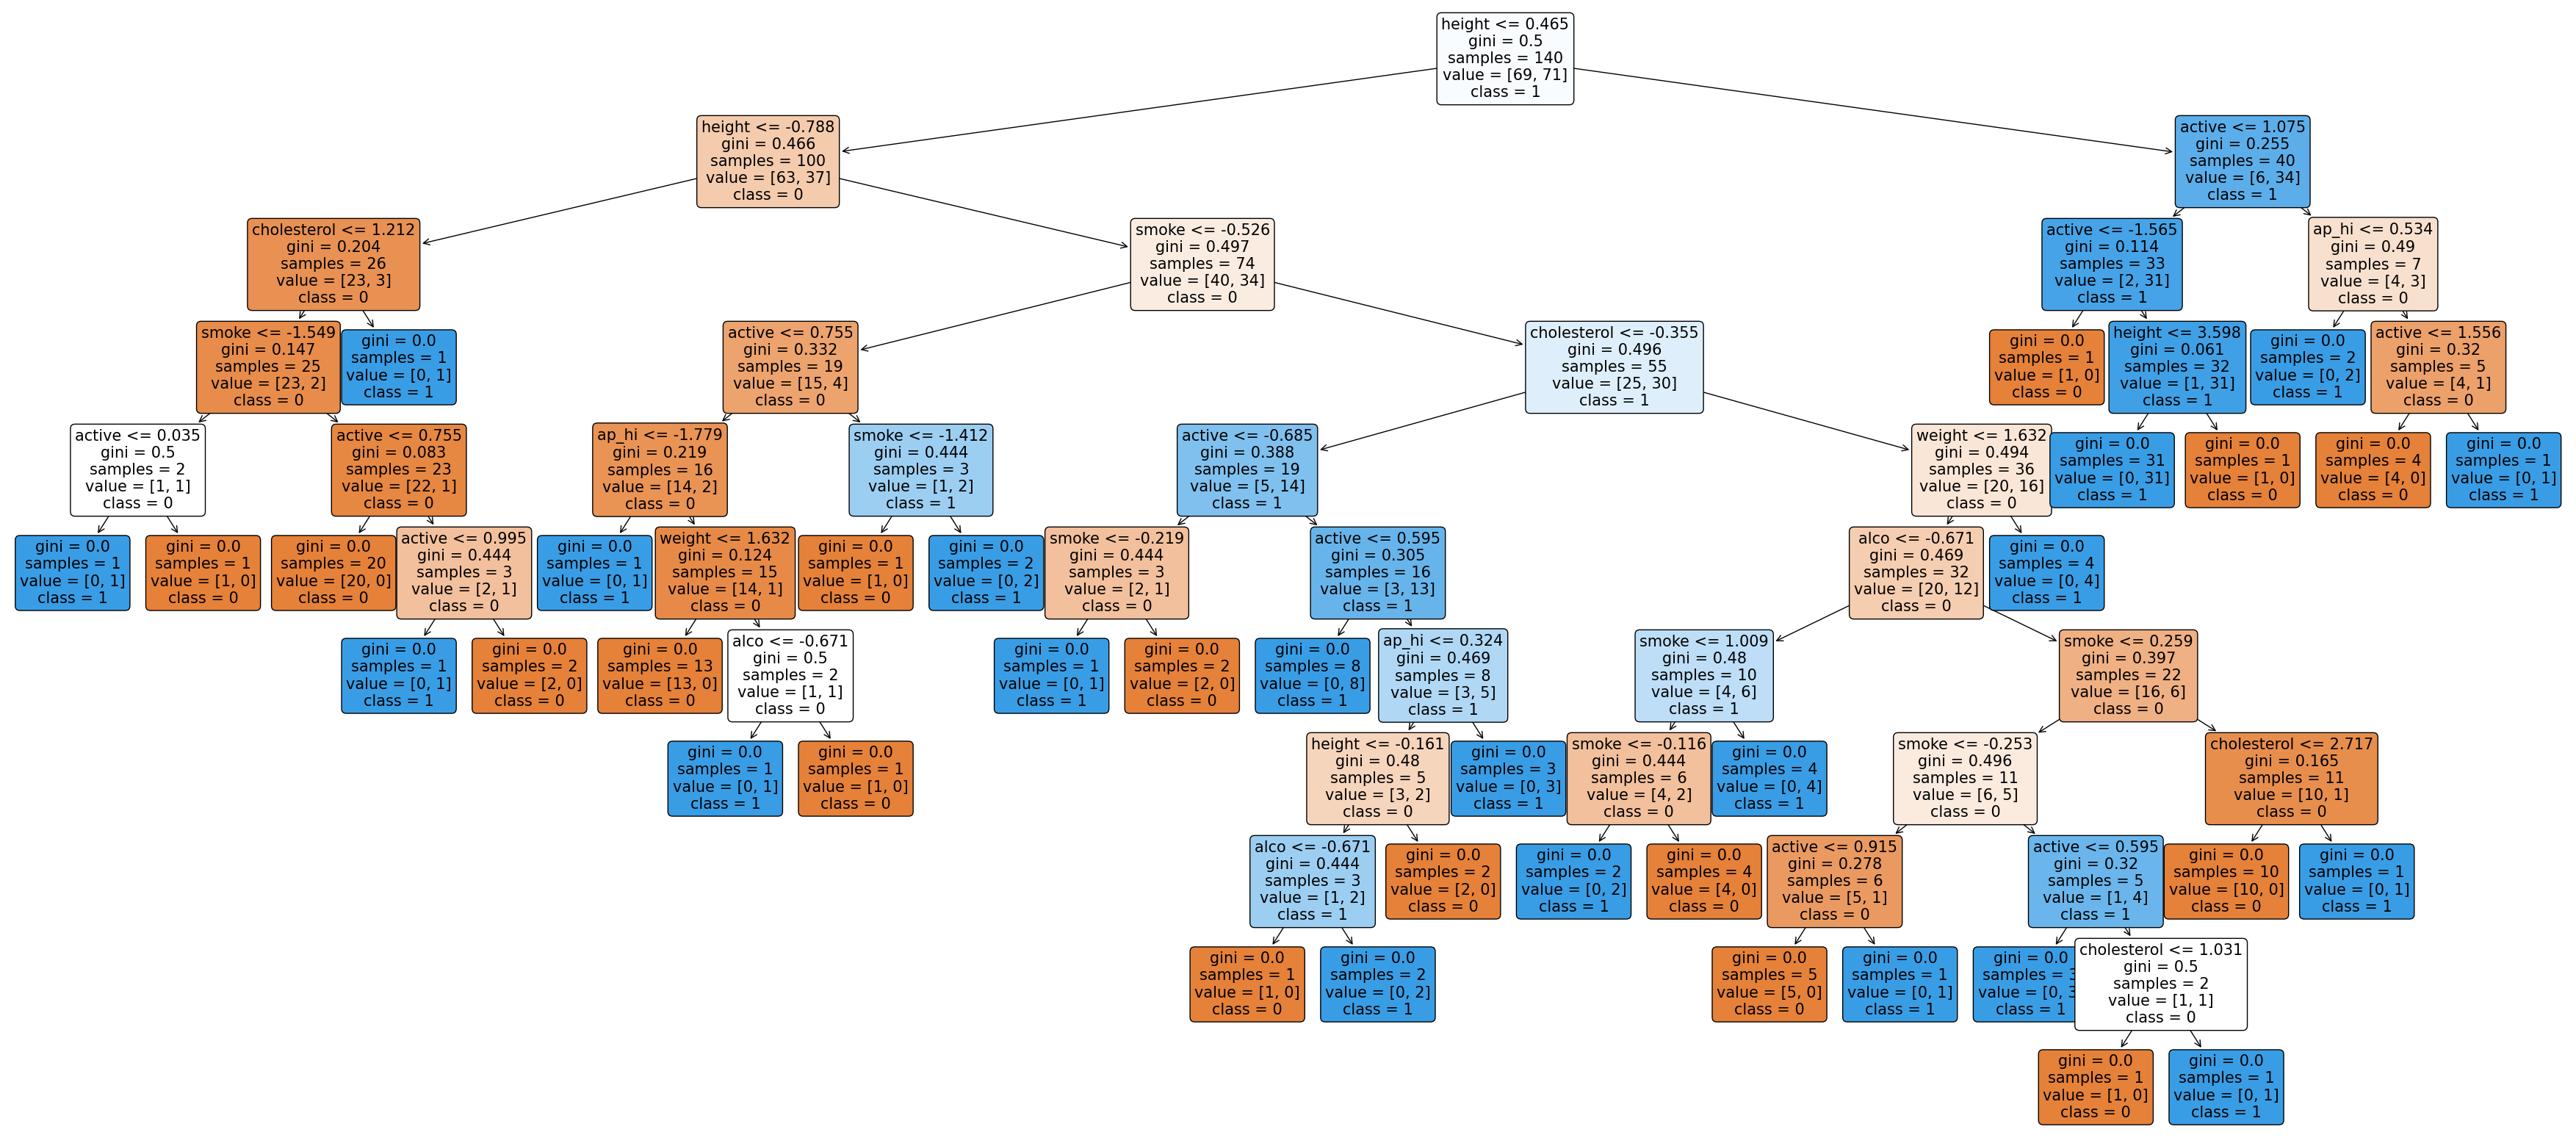

In [40]:
#---------Decision Tree Visualize ----------------------------
plt.figure(figsize=(45,20))
dtree_plot = tree.plot_tree(models["Decision Tree"],
        feature_names = ['alco', 'active', 'age', 'height', 'ap_hi', 'weight', 'ap_lo', 'cholesterol', 'gluc', 'smoke'],
        class_names = np.array(sorted(y_feat.unique())).astype('str').tolist(), label="all", rounded=True,
                   
                            
        filled = True,fontsize = 15)
#plt.savefig("C:\\Users\Kasutaja\\Downloads\\treeHealth_picture2.png")
plt.show()
       

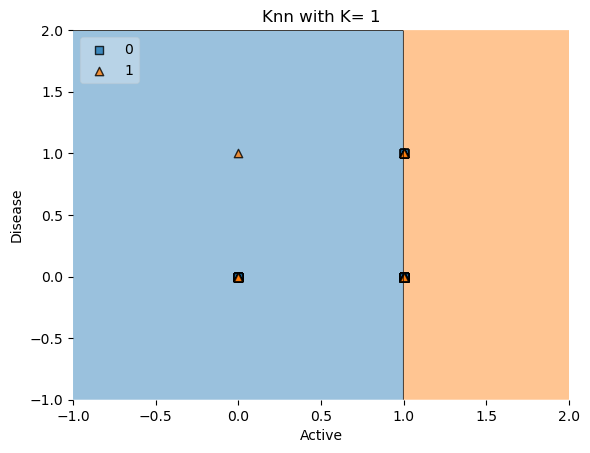

In [41]:
#------ Plotted the Decision Boundary--------
x = data[['active','smoke']].values
y = data['disease'].astype(int).values
clf = KNeighborsClassifier()
clf.fit(x, y)

plot_decision_regions(x,y,clf=clf,legend=2)    
plt.xlabel('Active')
plt.ylabel('Disease')
plt.title('Knn with K= 1')
plt.show()
    